# Perform time series analysis and prediction using ARIMA

## Import libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from joblib import dump
from joblib import load

In [47]:
df = pd.read_csv("./data/processed/mastercard_processed.csv", parse_dates = True, index_col = ["Date"])
df.head()

,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD
Date,,,,,,,,,,
2006-06-29,4.367592,14470000.0,4.46527,6,3,2,4.368524,4.401083,4.325699,0.125787
2006-06-30,4.432710,25964000.0,4.46527,6,4,2,4.465270,4.368524,4.338103,0.120293
2006-07-01,4.432710,25964000.0,4.46527,7,5,3,4.465270,4.465270,4.347592,0.118657
2006-07-02,4.432710,25964000.0,4.46527,7,6,3,4.465270,4.465270,4.349111,0.119898
2006-07-03,4.455966,7029000.0,4.40015,7,0,3,4.465270,4.465270,4.352243,0.121711


## Exploratory data analysis

Maybe we can implement an ARIMAX model, to predict close price, using features such as:

1. Lagged days opening prices
2. Previous days' open, volume
3. Moving average standard deviations and mean prices

We will fit a model to this to see if it works

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6743 entries, 2006-06-29 to 2024-12-13
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     6743 non-null   float64
 1   Volume   6743 non-null   float64
 2   Close    6743 non-null   float64
 3   month    6743 non-null   int64  
 4   day      6743 non-null   int64  
 5   quarter  6743 non-null   int64  
 6   lag_1    6743 non-null   float64
 7   lag_2    6743 non-null   float64
 8   MA       6743 non-null   float64
 9   M_STD    6743 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 579.5 KB


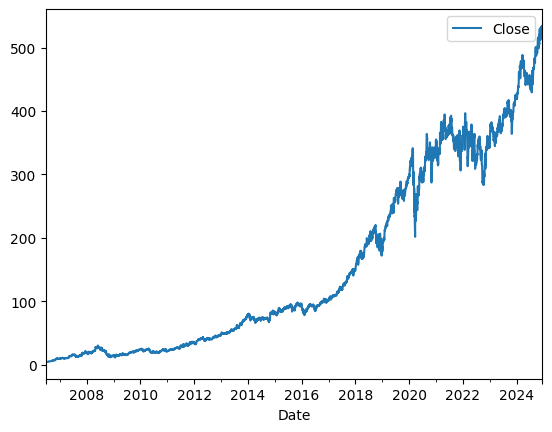

In [49]:
# plot the time series of Mastercard over the years
df.plot(y = "Close")
plt.show()

We can see that the time series is definitely not stationary.

This is because we can see that mean opening price increases over time. Furthermore, the variance of the time series seems to have increased after 2018

<Axes: xlabel='Date'>

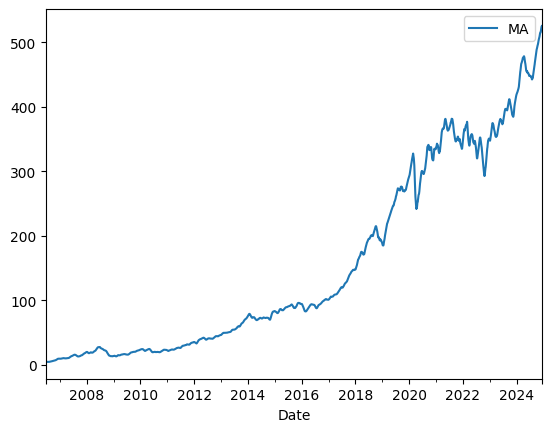

In [50]:
# plot the lag-1 rolling 30 day average of the time series

df.plot(y = 'MA')

The trend is more smoothed, but we can still see a lot of variation

<Axes: xlabel='Date'>

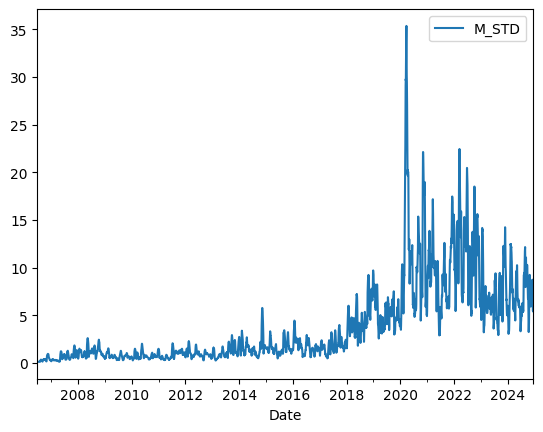

In [51]:
# plot the lag-1 30 day rolling standard deviation of the time series

df.plot(y = "M_STD")

Variance of the time series spiked around 2020

## Check for stationarity of time series

In [52]:
# we will use the adfuller test
# null hypothesis: time series is not stationary
# alternative hypothesis: time series is stationary

results = adfuller(df["Close"])
print(f"Test statistic: {results[0]}")
print(f"p-value: {results[1]}")

Test statistic: 1.5980463569922478
p-value: 0.9978517028218775


Since the p-value is very close to 1, we cannot reject the null hypothesis that the time series is not stationary

## Make time series stationary

<Axes: xlabel='Date'>

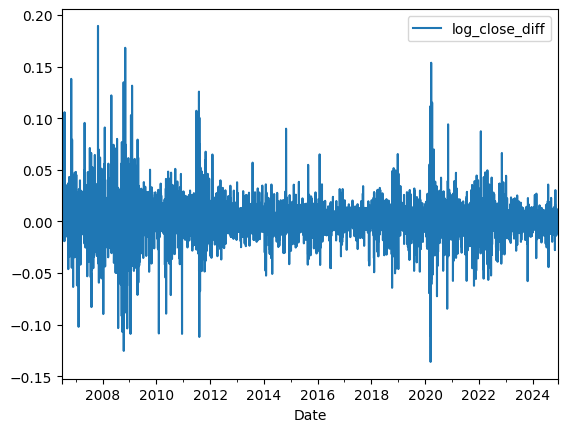

In [53]:
# apply log-transform so that variance is constant over time
df["log_close"] = np.log(df["Close"])
df["log_close_diff"] = np.log(df["Close"]).diff()
df = df.dropna()
df.plot(y = "log_close_diff")

Now the time series is definitely stationary. We can predict on this transformed time series, then perform integration of time series and the reverse of log-transform to get back to our actual predicted values

In [54]:
# we will use the adfuller test
# null hypothesis: time series is not stationary
# alternative hypothesis: time series is stationary

results = adfuller(df["log_close_diff"])
print(f"Test statistic: {results[0]}")
print(f"p-value: {results[1]}")

Test statistic: -13.553543780129699
p-value: 2.3838834193027704e-25


After first-order differencing, the p-value for the Augmented Dickey-Fuller Test is now extremely small. We can reject the null hypothesis (time series is not stationary) at level 0.001.

As such, we will use d = 1 in our ARIMAX model on the `log_close` column

## ACF and PACF plots

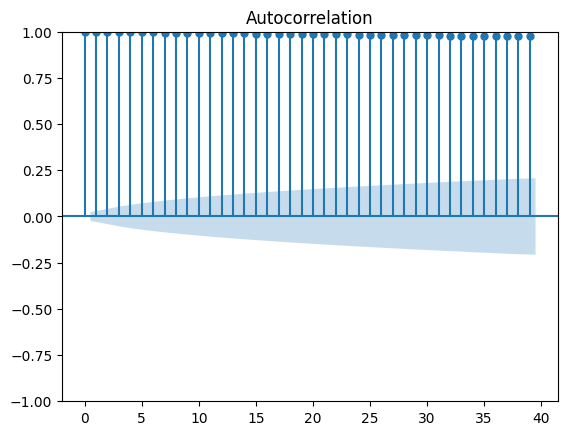

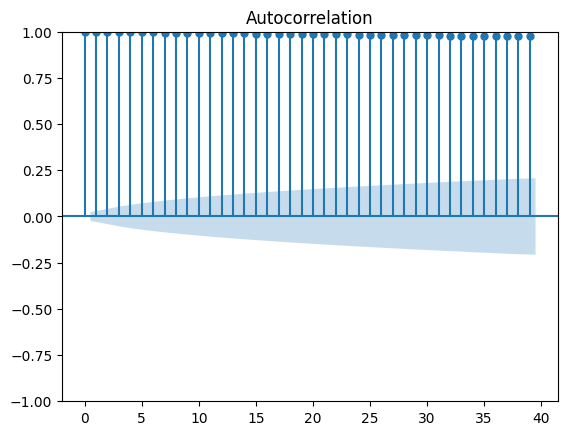

In [55]:
plot_acf(df['log_close'])

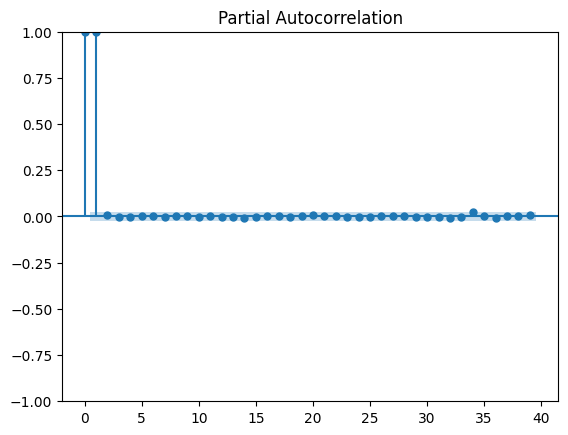

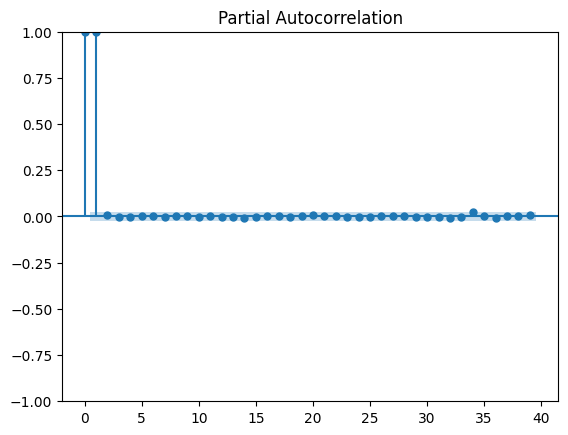

In [56]:
plot_pacf(df['log_close'])

The ACF plot tails off, while the PACF plot cuts off after p = 2. This suggests p = 2 for our ARIMA(p, d, q) model, and q = 0

## Standardize other variables we want to use in modelling

In [57]:
df.head()

,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD,log_close,log_close_diff
Date,,,,,,,,,,,,
2006-06-30,4.432710,25964000.0,4.46527,6,4,2,4.46527,4.368524,4.338103,0.120293,1.496330,0.000000
2006-07-01,4.432710,25964000.0,4.46527,7,5,3,4.46527,4.465270,4.347592,0.118657,1.496330,0.000000
2006-07-02,4.432710,25964000.0,4.46527,7,6,3,4.46527,4.465270,4.349111,0.119898,1.496330,0.000000
2006-07-03,4.455966,7029000.0,4.40015,7,0,3,4.46527,4.465270,4.352243,0.121711,1.481639,-0.014691
2006-07-04,4.455966,7029000.0,4.40015,7,1,3,4.40015,4.465270,4.353204,0.121980,1.481639,0.000000


In [58]:
scaler = StandardScaler()
# the below are also regressors we will use to predict the price of the stock (log_close)
cols_to_standardize = ["Open", "Volume", "MA", "M_STD"]
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])

## Fitting the ARIMAX model

In [59]:
cols_to_keep = ["Open", "Volume", "MA", "M_STD", "log_close", "Close"]
df1 = df[cols_to_keep]

In [60]:
# fit on all data except last 20 days

model = ARIMA(
    endog = df1['log_close'][:-20],
    exog = df1[["Open", "Volume", "MA", "M_STD"]][:-20],
    order = (2, 1, 0)
)

result = model.fit()

d:\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [61]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              log_close   No. Observations:                 6722
Model:                 ARIMA(2, 1, 0)   Log Likelihood               18017.404
Date:                Thu, 19 Dec 2024   AIC                         -36020.808
Time:                        22:08:02   BIC                         -35973.117
Sample:                    06-30-2006   HQIC                        -36004.340
                         - 11-23-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open           0.2242      0.006     36.907      0.000       0.212       0.236
Volume         0.0014    7.2e-05     20.076      0.000       0.001       0.002
MA            -0.1870      0.038     -4.917      0.000      -0.261      -0.112
M_STD         -0.0016      0.002     -0.635      0.526      -0.006       0.003
ar.L1         -0.1332      0.007    -18.242      0.000      -0.147      -0.119
ar.L2         -0.0120      0.007     -1.616      0.106      -0.027       0.003
sigma2         0.0003   1.77e-06    154.850      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             48738.07
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
# create one-step ahead predictions

forecast = result.get_prediction(start = df1.index[-20], end = df1.index[-1], exog = df1[["Open", "Volume", "MA", "M_STD"]][-20:])
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [63]:
mean_forecast.values

array([6.25493551, 6.26169365, 6.27016997, 6.27097759, 6.26987207,
       6.27547491, 6.27455779, 6.27334602, 6.27151704, 6.27325978,
       6.25594043, 6.25700834, 6.25396627, 6.25364589, 6.25323132,
       6.26238134, 6.25248388, 6.26244859, 6.27295187, 6.26953468])

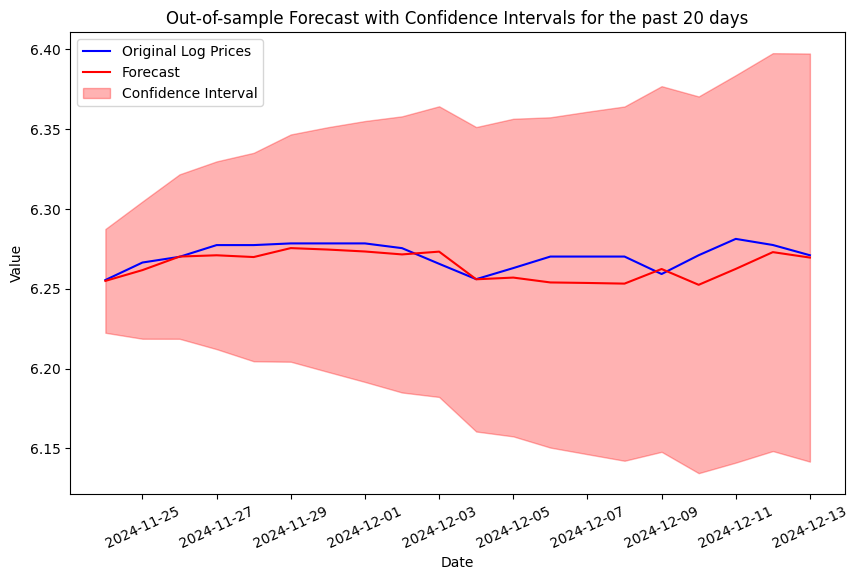

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(df1.index[-20:], df1['log_close'][-20:], label = "Original Log Prices", color = "blue")
plt.plot(mean_forecast.index, mean_forecast.values, label = "Forecast", color = "red")

plt.fill_between(
    mean_forecast.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color = "red",
    alpha = 0.3,
    label = "Confidence Interval"
)

# Add labels and title
plt.title("Out-of-sample Forecast with Confidence Intervals for the past 20 days")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation = 25)
plt.legend()

# Show the plot
plt.show()

We can see that our confidence intervals for prediction expectedly increases as our time horizon increases

In [65]:
# calculate the MSE of our predictions against the actual log values
mse = mean_squared_error(df1['log_close'][-20:], mean_forecast.values)
print(f"MSE of our model: {mse}")
print(f"AIC of our model: {result.aic}")

MSE of our model: 9.143103854526226e-05
AIC of our model: -36020.80759429931


## Plot our predictions against the actual prices

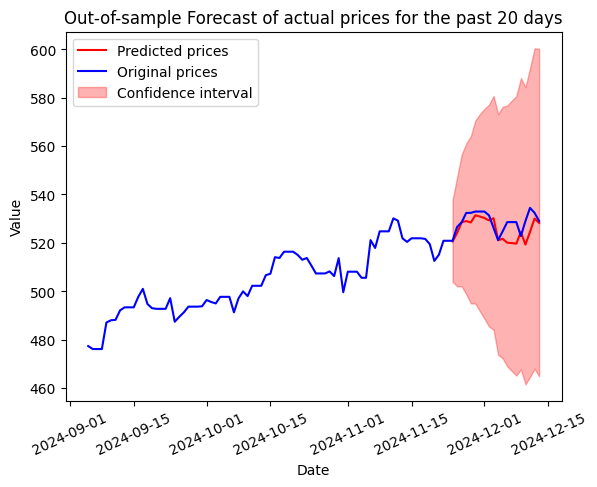

In [66]:
predicted_prices = np.exp(mean_forecast)
conf_int = np.exp(confidence_intervals)

plt.plot(predicted_prices, color = "red", label = "Predicted prices")
plt.plot(df1['Close'][-100:], label = "Original prices", color = "blue")

plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color = "red",
    alpha = 0.3,
    label = "Confidence interval"
)

# Add labels and title
plt.title("Out-of-sample Forecast of actual prices for the past 20 days")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation = 25)

# Show the plot
plt.show()

plt.show()

In [67]:
mse = mean_squared_error(df1['Close'][-20:], np.exp(mean_forecast.values))
print(f"Root mean-squared error of our predictions: {np.sqrt(mse): .2f}")

Root mean-squared error of our predictions:  5.03


## Save the trained model

In [68]:
dump(result, "./models/arimax_model.pkl")

['./models/arimax_model.pkl']

In [69]:
# test loading of model
loaded_model = load("./models/arimax_model.pkl")
forecast = loaded_model.get_prediction(start = df1.index[-20], end = df1.index[-1], exog = df1[["Open", "Volume", "MA", "M_STD"]][-20:])
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [70]:
mean_forecast.values

array([6.25493551, 6.26169365, 6.27016997, 6.27097759, 6.26987207,
       6.27547491, 6.27455779, 6.27334602, 6.27151704, 6.27325978,
       6.25594043, 6.25700834, 6.25396627, 6.25364589, 6.25323132,
       6.26238134, 6.25248388, 6.26244859, 6.27295187, 6.26953468])

It gives the same forecast values, so our model is successfully saved and loaded